In [1]:
from tabpfn_client import TabPFNRegressor

## Data Generation

In [2]:
import numpy as np

N_COMPLETE_BASE_PERIODS = 2
N_POINTS = 4000


In [3]:
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

freq_multipliers = range(1, 64+1)
phase_shifts = [0]
amplitude = 1

x = np.linspace(0, N_COMPLETE_BASE_PERIODS, N_POINTS)

freq_multipliers = np.array(freq_multipliers)
phase_shifts = np.array(phase_shifts) * 2 * np.pi


sine_waves = []
for freq in freq_multipliers:
    for phase in phase_shifts:
        sine_waves.append(np.sin(x * 2 * np.pi * freq + phase))

sine_waves = np.array(sine_waves)



In [4]:
train_test_split = int(N_POINTS / 10 * 6)

In [5]:
# Find the number of samples per cycle for the highest frequency
samples_per_cycle = N_POINTS / (freq_multipliers[-1] * N_COMPLETE_BASE_PERIODS)
print(f"Number of samples per cycle: {samples_per_cycle}")


Number of samples per cycle: 31.25


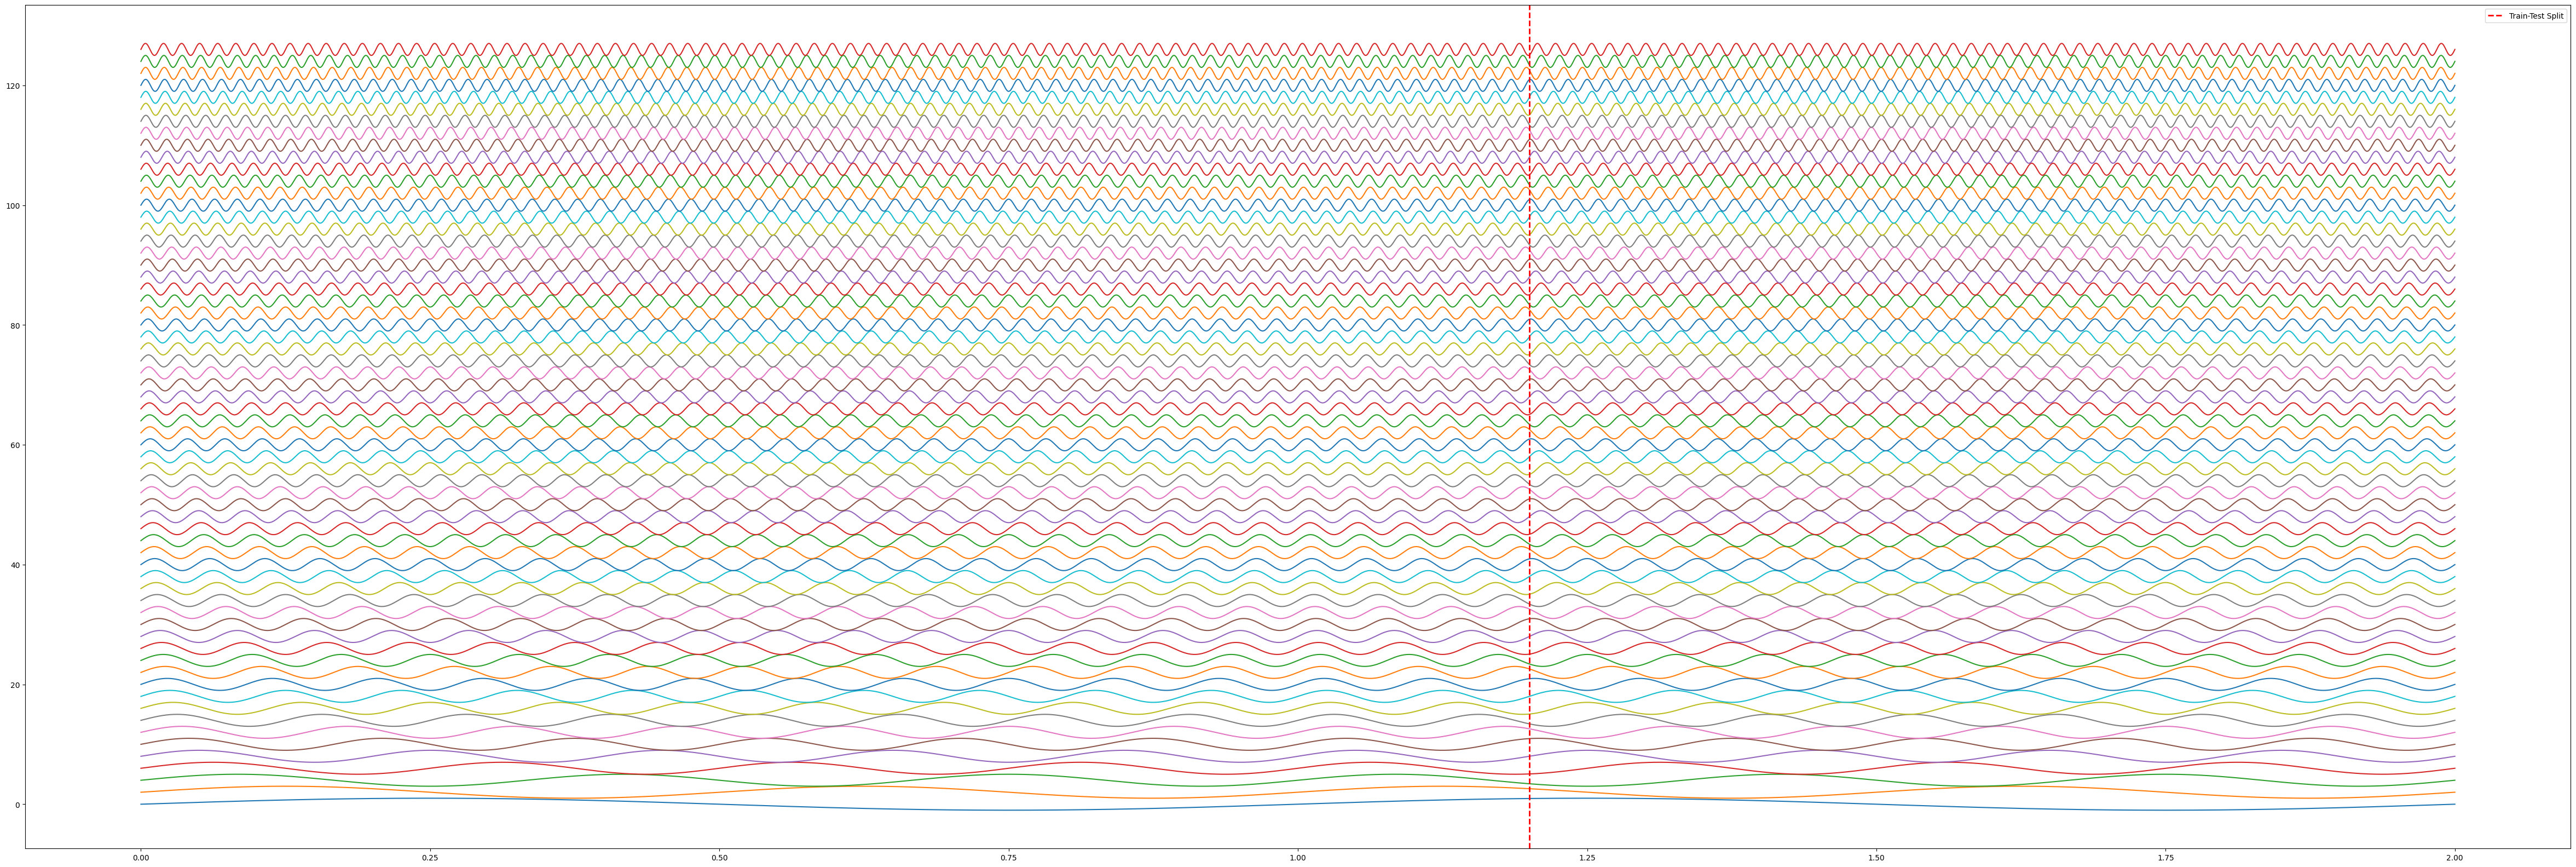

In [6]:
plt.figure(figsize=(60, 20))
for i in range(len(sine_waves)):
    plt.plot(x, sine_waves[i] + i // len(phase_shifts) * amplitude * 2)

# Add a vertical line at the train-test split point
plt.axvline(x=x[train_test_split], color='r', linestyle='--', linewidth=2, label='Train-Test Split')
plt.legend()

plt.show()

## Plotting

In [7]:
def plot_sine_wave_predictions(x, sine_waves, preds, train_test_split, 
                              plot_lower_freq=1, plot_upper_freq=24, use_scatter=False, 
                              save_path='sine_waves_generalization.pdf',
                              figsize=(16, 8)):
    """
    Plot sine wave predictions against actual values.
    
    Args:
        x: Time values
        sine_waves: Array of sine waves
        preds: Predicted values
        train_test_split: Index where training data ends and test data begins
        amplitude: Amplitude of sine waves
        phase_shifts: Phase shifts used for sine waves
        plot_lower_freq: Lower frequency to plot (default: 1)
        plot_upper_freq: Upper frequency to plot (default: 24)
        use_scatter: Whether to use scatter plot (default: False)
        save_path: Path to save the figure (default: 'sine_waves_generalization.pdf')
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    n_sine_waves_to_plot = plot_upper_freq - plot_lower_freq + 1
    
    # Create a figure with reduced margins
    plt.figure(figsize=figsize)
    
    # Plot a few examples
    for i in range(plot_lower_freq - 1, plot_upper_freq):
        plot_offset = i * 2
        
        if use_scatter:
            plt.scatter(x, sine_waves[i] + plot_offset, alpha=0.3, color='gray', s=0.5)
            plt.scatter(x[train_test_split:], preds[i] + plot_offset, s=0.5, alpha=0.5, marker='x', rasterized=True)
        else:
            plt.plot(x, sine_waves[i] + plot_offset, alpha=0.3, color='gray', linewidth=1, rasterized=True)
            plt.plot(x[train_test_split:], preds[i] + plot_offset, alpha=0.8, linewidth=1, rasterized=True)
    
    # Mark the train/test boundary
    plt.axvline(x=x[train_test_split], color='gray', linestyle='-', label='train/test split', alpha=0.9, linewidth=2)
    
    # Set y-ticks to show the number of sine waves with proper positioning
    y_tick_positions = [i * 2 for i in range(plot_lower_freq - 1, plot_upper_freq)]
    y_tick_labels = [f"sin({i+1}x)" for i in range(plot_lower_freq - 1, plot_upper_freq)]
    plt.yticks(ticks=y_tick_positions, labels=y_tick_labels)
    
    plt.xlabel('Time Units')
    
    # Move legend to top left
    plt.legend(loc='upper left')    
    
    # Move y-ticks to the right side
    plt.tick_params(left=False, right=True, labelleft=False, labelright=True)
    
    # Use tight_layout to make the figure tighter
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [8]:
def calculate_and_plot_smape(sine_waves, preds, train_test_split, threshold=5, 
                            figsize=(6, 6), save_path='sine_waves_generalization_smape.pdf'):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE) for each sine wave and plot the results.
    
    Parameters:
    -----------
    sine_waves : array-like
        Original sine waves data
    preds : array-like
        Predicted values for each sine wave
    train_test_split : int
        Index where training data ends and test data begins
    threshold : float, optional
        Threshold line to display on the plot (default: 5)
    figsize : tuple, optional
        Figure size for the plot (default: (6, 6))
    save_path : str, optional
        Path to save the figure (default: 'sine_waves_generalization_smape.pdf')
        
    Returns:
    --------
    numpy.ndarray
        Array of SMAPE scores for each sine wave
    """
    # Calculate Symmetric Mean Absolute Percentage Error (SMAPE) for each sine wave
    smape_scores = []

    for i in range(len(sine_waves)):
        # Calculate SMAPE between the original sine wave and predictions
        actual = sine_waves[i][train_test_split:]
        predicted = preds[i]
        smape = np.mean(2.0 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + 1e-8)) * 100
        
        # use 100% smape
        smape /= 2
        smape_scores.append(smape)

    # Convert to numpy array for easier analysis
    smape_scores = np.array(smape_scores)

    # Plot the SMAPE scores
    plt.figure(figsize=figsize)
    plt.bar(range(len(smape_scores)), smape_scores)
    plt.axhline(y=threshold, color='r', linestyle='--', label='5% Threshold')
    plt.xlabel('Frequency Multiplier')
    plt.ylabel('SMAPE (%)')
    # plt.title('SMAPE for Each Sine Wave')
    # plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
    plt.yticks(list(plt.yticks()[0]) + [threshold])  # Add threshold to y-ticks

    # Set x-ticks to show every 5th element
    x_tick_positions = range(0, len(smape_scores), 5)
    x_tick_labels = [i+1 for i in x_tick_positions]  # +1 for 1-based indexing
    plt.xticks(x_tick_positions, x_tick_labels, rotation=45)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    return smape_scores

## Prediction Routine

In [9]:
import concurrent.futures
from tabpfn_client import set_access_token
from dotenv import load_dotenv
import os

load_dotenv()

set_access_token(os.getenv("TABPFN_ACCESS_TOKEN"))


def predict_multiple_series(x_train, y_train, x_test):
    """
    Predict multiple time series in parallel using TabPFNRegressor.
    
    Args:
        x_train: Training features
        y_train: Training targets, shape (n_series, n_train_samples)
        x_test: Test features
        
    Returns:
        np.array: Predictions for all series, shape (n_series, n_test_samples)
    """
    def predict_routine(x_train, y_train, x_test):
        tabpfn = TabPFNRegressor()
        tabpfn.fit(x_train, y_train)
        pred = tabpfn.predict(x_test)
        return pred

    # Use ThreadPoolExecutor for parallel processing
    preds = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit prediction tasks for all samples
        futures = []
        for i in range(y_train.shape[0]):
            futures.append(executor.submit(predict_routine, x_train, y_train[i], x_test))
        
        # Process results in the same order as input
        for i in range(len(futures)):
            pred = futures[i].result()
            preds.append(pred)

    return np.array(preds)

## Featurization

In [10]:
sin_X = np.array([
    np.sin(x * 2 * np.pi),
    # np.cos(x * 2 * np.pi),
]).transpose()

sin_X_cos_X = np.array([
    np.sin(x * 2 * np.pi),
    np.cos(x * 2 * np.pi),
]).transpose() 

### Sin(x)

In [11]:
train_sin_X = sin_X[:train_test_split]
test_sin_X = sin_X[train_test_split:]

train_sin_y = np.array(sine_waves[:, :train_test_split])
# test_sin_y = np.array(sine_waves[:, train_test_split:])

In [12]:
sin_preds = predict_multiple_series(train_sin_X, train_sin_y, test_sin_X)


Processing:   0%|          | [00:00<?]
Processing:   1%|          | [00:00<00:10]


Processing:   2%|▏         | [00:00<00:10]


Processing:   3%|▎         | [00:00<00:10]


Processing:   4%|▎         | [00:00<00:10]









Processing:   5%|▍         | [00:00<00:10]














Processing:   5%|▌         | [00:00<00:10]














Processing:   6%|▋         | [00:00<00:10]














Processing:   7%|▋         | [00:00<00:10]



























Processing:   8%|▊         | [00:00<00:10]



























Processing:   9%|▉         | [00:01<00:10]



































Processing:  10%|█         | [00:01<00:09]



































Processing:  11%|█         | [00:01<00:09]



































Processing:  12%|█▏        | [00:01<00:09]












































Processing:  13%|█▎        | [00:01<00:09]








Processing: 100%|██████████| [00:01<00:00]







































Processing: 100%|██████████| [00:01<00:00]



























Processing: 100%|██████████| [00:01<00:00]












































Processing:   1%|          | [00:00<00:10]











































Processing:   2%|▏         | [00:00<00:10]











































Processing:   3%|▎         | [00:00<00:10]











































Processing:   4%|▎         | [00:00<00:10]











































Processing:   5%|▍         | [00:00<00:10]












































Processing:   5%|▌         | [00:00<00:10]












































Processing:   6%|▋         | [00:00<00:10]












































Processing:   7%|▋         | [00:00<00:10]














Processing: 100%|██████████| [00:01<00:00]











Processing: 100%|██████████| [00:02<00:00]



















Processing:   8%|▊         | [00:00<00:10]



Processi

RuntimeError: Fail to call predict with error: 500, reason: Internal Server Error and text: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/starlette/middleware/errors.py", line 165, in __call__
    await self.app(scope, receive, _send)
  File "/usr/local/lib/python3.10/site-packages/starlette/middleware/exceptions.py", line 62, in __call__
    await wrap_app_handling_exceptions(self.app, conn)(scope, receive, send)
  File "/usr/local/lib/python3.10/site-packages/starlette/_exception_handler.py", line 62, in wrapped_app
    raise exc
  File "/usr/local/lib/python3.10/site-packages/starlette/_exception_handler.py", line 51, in wrapped_app
    await app(scope, receive, sender)
  File "/usr/local/lib/python3.10/site-packages/starlette/routing.py", line 715, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.10/site-packages/starlette/routing.py", line 735, in app
    await route.handle(scope, receive, send)
  File "/usr/local/lib/python3.10/site-packages/starlette/routing.py", line 288, in handle
    await self.app(scope, receive, send)
  File "/usr/local/lib/python3.10/site-packages/starlette/routing.py", line 76, in app
    await wrap_app_handling_exceptions(app, request)(scope, receive, send)
  File "/usr/local/lib/python3.10/site-packages/starlette/_exception_handler.py", line 62, in wrapped_app
    raise exc
  File "/usr/local/lib/python3.10/site-packages/starlette/_exception_handler.py", line 51, in wrapped_app
    await app(scope, receive, sender)
  File "/usr/local/lib/python3.10/site-packages/starlette/routing.py", line 73, in app
    response = await f(request)
  File "/usr/local/lib/python3.10/site-packages/fastapi/routing.py", line 291, in app
    solved_result = await solve_dependencies(
  File "/usr/local/lib/python3.10/site-packages/fastapi/dependencies/utils.py", line 588, in solve_dependencies
    solved_result = await solve_dependencies(
  File "/usr/local/lib/python3.10/site-packages/fastapi/dependencies/utils.py", line 613, in solve_dependencies
    solved = await run_in_threadpool(call, **solved_result.values)
  File "/usr/local/lib/python3.10/site-packages/starlette/concurrency.py", line 39, in run_in_threadpool
    return await anyio.to_thread.run_sync(func, *args)
  File "/usr/local/lib/python3.10/site-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2470, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 967, in run
    result = context.run(func, *args)
  File "/code/tabpfn-server/app/dependencies.py", line 115, in get_current_user
    status, user = user_auth.get_user_by_token(token)
  File "/code/tabpfn-server/app/services/user_auth_service.py", line 556, in get_user_by_token
    user = self._user_repo.get_by_uid(token_data["user"])
  File "/code/tabpfn-server/app/db/crud.py", line 28, in get_by_uid
    return self._db.query(m.User).filter(m.User.uid == user_uid).first()
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/orm/query.py", line 2728, in first
    return self.limit(1)._iter().first()  # type: ignore
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/orm/query.py", line 2827, in _iter
    result: Union[ScalarResult[_T], Result[_T]] = self.session.execute(
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/orm/session.py", line 2362, in execute
    return self._execute_internal(
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/orm/session.py", line 2237, in _execute_internal
    conn = self._connection_for_bind(bind)
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/orm/session.py", line 2106, in _connection_for_bind
    return trans._connection_for_bind(engine, execution_options)
  File "<string>", line 2, in _connection_for_bind
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/orm/state_changes.py", line 139, in _go
    ret_value = fn(self, *arg, **kw)
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/orm/session.py", line 1189, in _connection_for_bind
    conn = bind.connect()
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/engine/base.py", line 3278, in connect
    return self._connection_cls(self)
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/engine/base.py", line 146, in __init__
    self._dbapi_connection = engine.raw_connection()
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/engine/base.py", line 3302, in raw_connection
    return self.pool.connect()
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 449, in connect
    return _ConnectionFairy._checkout(self)
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1263, in _checkout
    fairy = _ConnectionRecord.checkout(pool)
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 712, in checkout
    rec = pool._do_get()
  File "/usr/local/lib/python3.10/site-packages/sqlalchemy/pool/impl.py", line 168, in _do_get
    raise exc.TimeoutError(
sqlalchemy.exc.TimeoutError: QueuePool limit of size 50 overflow 20 reached, connection timed out, timeout 30.00 (Background on this error at: https://sqlalche.me/e/20/3o7r)


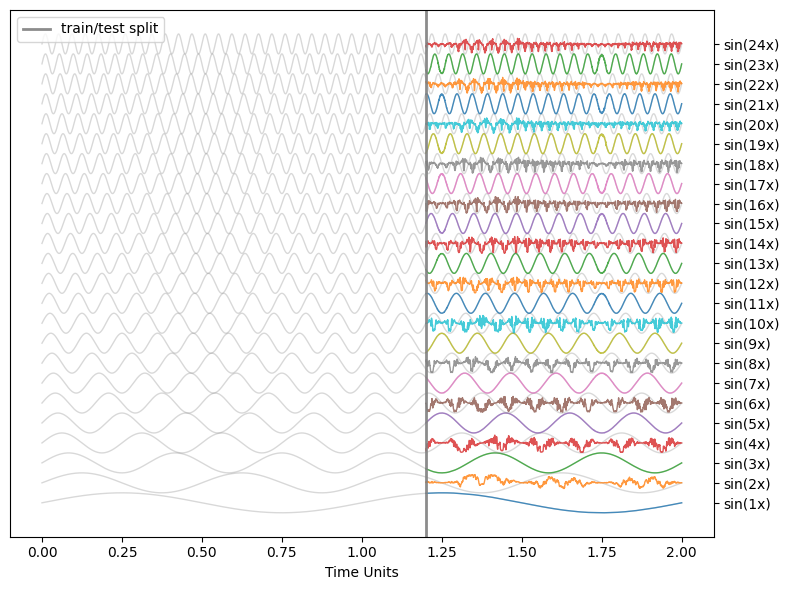

In [13]:
plot_sine_wave_predictions(x, sine_waves, sin_preds, train_test_split,
                           plot_lower_freq=1, plot_upper_freq=24,
                           save_path='sin_generalization.pdf',
                           figsize=(8, 6))


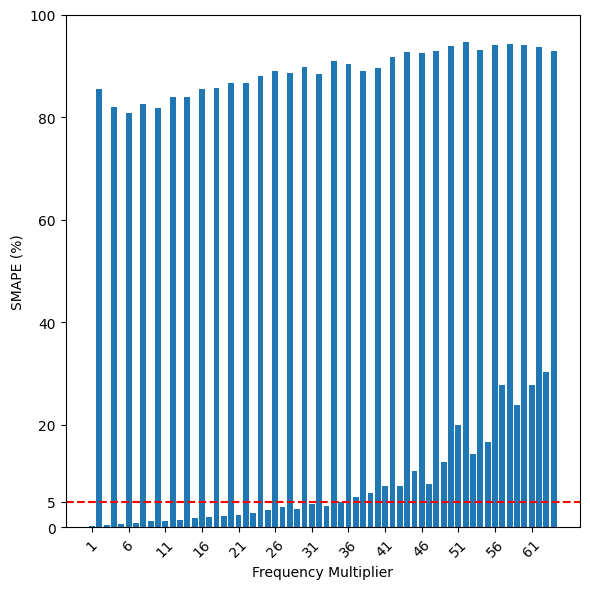

In [ ]:
# Calculate and plot SMAPE for the sine waves
sin_smape_scores = calculate_and_plot_smape(sine_waves, sin_preds, train_test_split)


### Sin(x) + Cos(x)

In [15]:
train_sin_X_cos_X = sin_X_cos_X[:train_test_split]
test_sin_X_cos_X = sin_X_cos_X[train_test_split:]

train_sin_y_cos_X = np.array(sine_waves[:, :train_test_split])


In [ ]:
sin_cos_preds = predict_multiple_series(train_sin_X_cos_X, train_sin_y_cos_X, test_sin_X_cos_X)

Processing:   2%|▏         | [00:00<00:10]
Processing:   3%|▎         | [00:00<00:10]
Processing:   4%|▎         | [00:00<00:10]
Processing:   5%|▍         | [00:00<00:10]
Processing:   5%|▌         | [00:00<00:10]
Processing:   6%|▋         | [00:00<00:10]
Processing:   7%|▋         | [00:00<00:10]





Processing:   8%|▊         | [00:00<00:10]





Processing:   9%|▉         | [00:01<00:10]





Processing:  10%|█         | [00:01<00:09]





Processing:  11%|█         | [00:01<00:09]





Processing:  12%|█▏        | [00:01<00:09]









Processing:  13%|█▎        | [00:01<00:09]









Processing:  14%|█▎        | [00:01<00:09]









Processing:  15%|█▍        | [00:01<00:09]









Processing: 100%|██████████| [00:01<00:00]
Processing:   0%|          | [00:00<?]









Processing: 100%|██████████| [00:01<00:00]
Processing:   1%|          | [00:00<00:10]









Processing:   2%|▏         | [00:00<00:10]









Processing:   3%|▎         | [00:00<00:10]









Proc

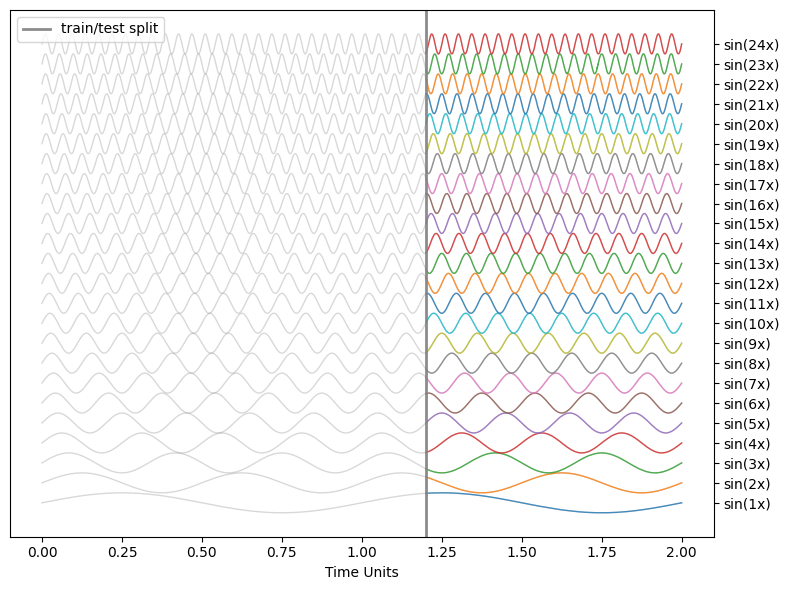

In [ ]:
plot_sine_wave_predictions(x, sine_waves, sin_cos_preds, train_test_split,
                           plot_lower_freq=1, plot_upper_freq=24,
                           save_path='sin_cos_generalization.pdf',
                           figsize=(8, 6))

In [ ]:
# Calculate and plot SMAPE for the sine waves
sin_cos_smape_scores = calculate_and_plot_smape(sine_waves, sin_cos_preds, train_test_split)


## Composition

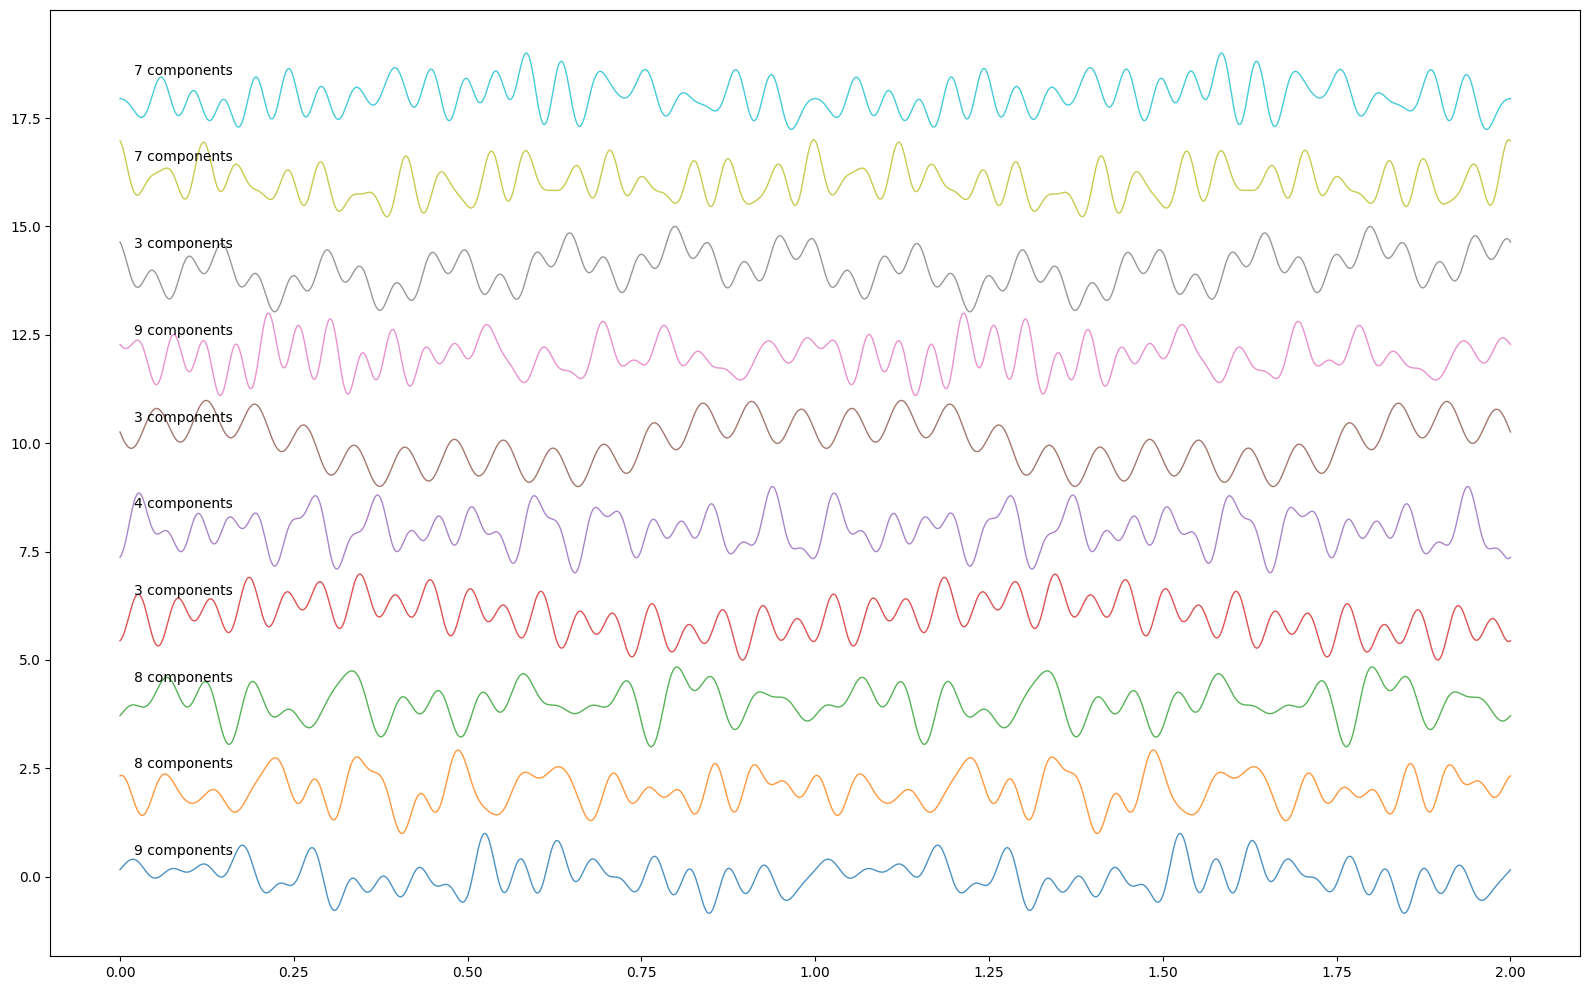

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Generate 5 composite sine waves by combining multiple sine waves with different frequencies
comp_train_test_split = int(0.6 * N_POINTS)
composite_freq_multipliers = range(1, 24+1)

# Create 5 different composite sine waves
composite_waves = []
composite_metadata = []  # Store metadata for each composite wave

for i in range(10):
    # For each composite wave, combine 3-5 sine waves with different frequencies and amplitudes
    n_components = np.random.randint(3, 10)  # Random number of components between 3 and 5
    
    # Initialize the composite wave with zeros
    composite = np.zeros(N_POINTS)
    
    # Store the components of this composite wave
    wave_components = []
    
    # Add the component sine waves
    for j in range(n_components):
        freq = np.random.choice(composite_freq_multipliers)  # Random frequency from our multipliers
        amplitude = np.random.uniform(0.5, 2.0)    # Random amplitude between 0.5 and 2.0
        phase = np.random.uniform(0, 2*np.pi)      # Random phase shift
        
        # Add this component to the composite wave
        composite += amplitude * np.sin(2 * np.pi * freq * x + phase)
        
        # Store the component information
        wave_components.append({
            'frequency': freq,
            'amplitude': amplitude,
            'phase': phase
        })
    
    # Normalize the composite wave to have amplitude around 1
    max_amplitude = np.max(np.abs(composite))
    composite = composite / max_amplitude
    
    # Store the metadata
    composite_metadata.append({
        'n_components': n_components,
        'components': wave_components,
        'max_amplitude': max_amplitude
    })
    
    composite_waves.append(composite)

# # Plot the composite waves
# plt.figure(figsize=(16, 10))
# for i, wave in enumerate(composite_waves):
#     plt.plot(x, wave + i * 2, alpha=0.8, linewidth=1, rasterized=True)
    
#     # Add text annotation showing the number of components
#     components_text = f"{composite_metadata[i]['n_components']} components"
#     plt.text(0.02, i * 2 + 0.5, components_text, fontsize=10)

# plt.tight_layout()
# plt.show()


composite_waves = np.array(composite_waves)


In [30]:
comp_train_y = np.array(composite_waves[:, :comp_train_test_split])
comp_test_y = np.array(composite_waves[:, comp_train_test_split:])
comp_train_x = sin_X_cos_X[:comp_train_test_split]
comp_test_x = sin_X_cos_X[comp_train_test_split:]


In [31]:
comp_preds = predict_multiple_series(comp_train_x, comp_train_y, comp_test_x)


Processing:   7%|▋         | [00:00<00:10]
Processing:   8%|▊         | [00:00<00:10]
Processing:   9%|▉         | [00:01<00:10]
Processing:  10%|█         | [00:01<00:09]
Processing:  11%|█         | [00:01<00:09]





Processing:  12%|█▏        | [00:01<00:09]





Processing:  13%|█▎        | [00:01<00:09]





Processing:  14%|█▎        | [00:01<00:09]









Processing:  15%|█▍        | [00:01<00:09]









Processing:  15%|█▌        | [00:01<00:09]











Processing: 100%|██████████| [00:01<00:00]



Processing:   0%|          | [00:00<?]




















Processing:   1%|          | [00:00<00:10]




















Processing:   2%|▏         | [00:00<00:10]




















Processing:   3%|▎         | [00:00<00:10]




















Processing:   4%|▎         | [00:00<00:10]



























Processing:   5%|▍         | [00:00<00:10]



























Processing:   5%|▌         | [00:00<00:10]



























Processing:   6%|▋    

KeyboardInterrupt: 

In [202]:
composite_metadata

[{'n_components': 9,
  'components': [{'frequency': 20,
    'amplitude': 1.9260714596148742,
    'phase': 4.599253580133889},
   {'frequency': 21,
    'amplitude': 0.7340279606636548,
    'phase': 0.9801424781769557},
   {'frequency': 11,
    'amplitude': 1.1888733379488008,
    'phase': 2.096753042388008},
   {'frequency': 8,
    'amplitude': 1.5621088666940683,
    'phase': 0.12933619211510794},
   {'frequency': 2,
    'amplitude': 1.582998158400237,
    'phase': 5.897100591301359},
   {'frequency': 2,
    'amplitude': 0.7727374508106509,
    'phase': 1.152364521581569},
   {'frequency': 12,
    'amplitude': 1.4174797407324213,
    'phase': 0.04439890513257482},
   {'frequency': 17,
    'amplitude': 1.2871619903875837,
    'phase': 2.5124005823958453},
   {'frequency': 16,
    'amplitude': 0.8491570106454563,
    'phase': 0.5692970181925487}],
  'max_amplitude': 8.047153584796675},
 {'n_components': 8,
  'components': [{'frequency': 19,
    'amplitude': 1.073692986900744,
    'phase'

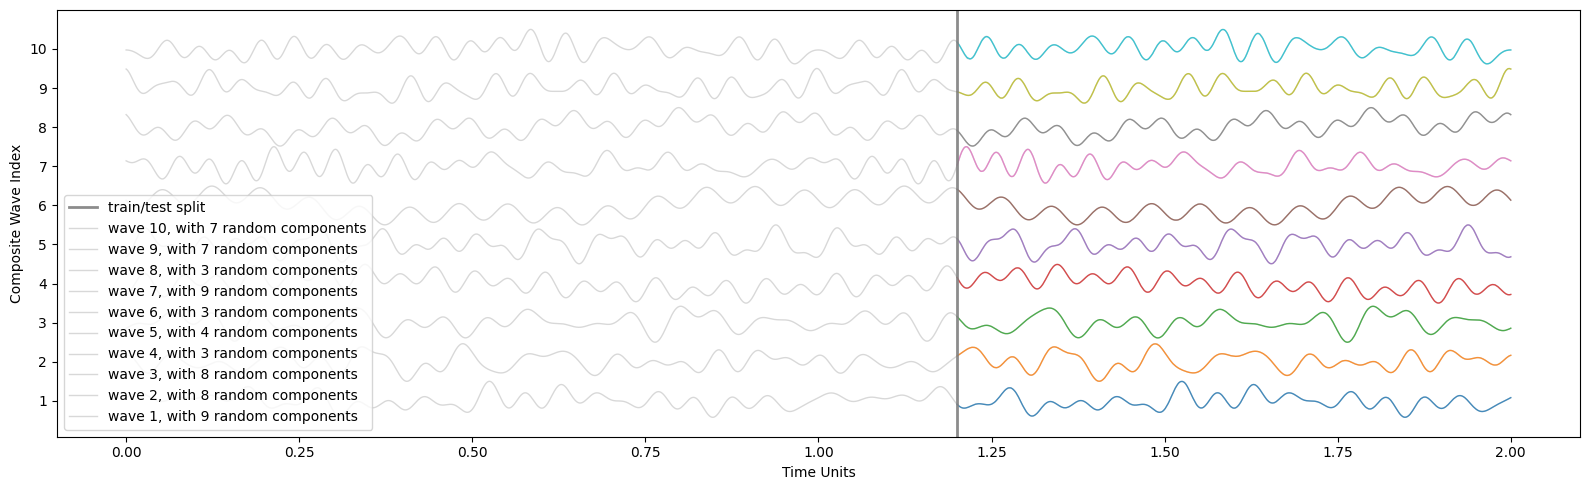

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

USE_SCATTER = False     # expensive to plot all points

# Create a figure with reduced margins
plt.figure(figsize=(16, 5))

# Plot a few examples (e.g., first 5)
for i in range(comp_preds.shape[0]):
    plot_offset = i * 2
    if USE_SCATTER:
        plt.scatter(x, composite_waves[i] + plot_offset, alpha=0.3, color='gray', s=0.5)
        plt.scatter(x[comp_train_test_split:], comp_preds[i] + plot_offset, s=0.5, alpha=0.5, marker='x', rasterized=True)
    else:
        plt.plot(x, composite_waves[i] + plot_offset, alpha=0.3, color='gray', linewidth=1, rasterized=True,
                 label=f"wave {i+1}, with {composite_metadata[i]['n_components']} random components")
        plt.plot(x[comp_train_test_split:], comp_preds[i] + plot_offset, alpha=0.8, linewidth=1, rasterized=True)
        # plt.plot(x, comp_preds[i] + plot_offset, alpha=0.8, linewidth=1, rasterized=True)
    
# Mark the train/test boundary
plt.axvline(x=x[comp_train_test_split], color='gray', linestyle='-', label='train/test split', alpha=0.9, linewidth=2)

# Set y-ticks to show the number of sine waves with proper positioning
y_tick_positions = [i * 2 for i in range(comp_preds.shape[0])]
y_tick_labels = range(1, comp_preds.shape[0] + 1)
plt.yticks(ticks=y_tick_positions, labels=y_tick_labels)

# Add y-axis label for frequency multiplier
plt.ylabel('Composite Wave Index')
plt.xlabel('Time Units')
# Create legend and reverse the order of handles and labels
legend = plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=list(reversed(handles)), labels=list(reversed(labels)))

# Use tight_layout to make the figure tighter
plt.tight_layout()
plt.savefig('composite_waves_generalization.pdf', bbox_inches='tight')
plt.show()

# save as pdf
